In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    ,
                   'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l4_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l4_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 372221 records
valid has 50316 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1523
0
26 36 (1, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1523/1523 [==============================] - 24s 16ms/step - loss: 0.2785 - total_loss: 0.2785 - reg_loss: 0.2785 - val_loss: 0.2564 - val_total_loss: 0.2564 - val_reg_loss: 0.2564
Epoch 2/100
1523/1523 [==============================] - 22s 14ms/step - loss: 0.2533 - total_loss: 0.2533 - reg_loss: 0.2533 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.956612 -0.027502  0.227775    7  2017-04-16
472     2.507290  2.536384 -0.029093  0.230584    1  2017-04-17
473     2.661330  2.694218 -0.032888  0.250346    2  2017-04-18
474     2.754815  2.772575 -0.017760  0.204717    3  2017-04-19
475     2.713762  2.734729 -0.020968  0.231878    4  2017-04-20
476     2.999000  2.998261  0.000739  0.153503    5  2017-04-21
477     3.075529  3.108414 -0.032885  0.185276    6  2017-04-22

0.212011250287
best_epochs [8, 6, 3, 7, 5]
(829, 1) 2.68769390927 

2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194744, 2) (50259, 2)
train/valid # (194744, 2) (50259, 2)
rand split across time
train has 194744 records out of 372221 records
valid has 50259 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1521
0
26 36 (2, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1521/1521 [==============================] - 28s 18ms/step - loss: 0.2866 - total_loss: 0.2866 - reg_loss: 0.2866 - val_loss: 0.2633 - val_total_loss: 0.2633 - val_reg_loss: 0.2633
Epoch 2/100
1521/1521 [==============================] - 28s 18ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.939899 -0.010789  0.236528    6  2017-04-15
471     2.507290  2.531820 -0.024530  0.231889    7  2017-04-16
472     2.661330  2.659879  0.001451  0.249503    1  2017-04-17
473     2.754815  2.747203  0.007612  0.211185    2  2017-04-18
474     2.713762  2.738463 -0.024702  0.237526    3  2017-04-19
475     2.999000  2.994723  0.004277  0.155390    4  2017-04-20
476     3.075529  3.104137 -0.028608  0.184263    5  2017-04-21

0.215183638963
best_epochs [5, 9, 3, 8, 2]
(829, 1) 2.5099481903 

3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194572, 2) (50216, 2)
train/valid # (194572, 2) (50216, 2)
rand split across time
train has 194572 records out of 372221 records
valid has 50216 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1520
0
26 36 (3, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1520/1520 [==============================] - 29s 19ms/step - loss: 0.2860 - total_loss: 0.2860 - reg_loss: 0.2860 - val_loss: 0.2667 - val_total_loss: 0.2667 - val_reg_loss: 0.2667
Epoch 2/100
1520/1520 [==============================] - 28s 19ms/step -

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.924403  0.004707  0.239350    5  2017-04-14
470     2.507290  2.535316 -0.028026  0.238028    6  2017-04-15
471     2.661330  2.685011 -0.023681  0.265003    7  2017-04-16
472     2.754815  2.769444 -0.014629  0.219300    1  2017-04-17
473     2.713762  2.735223 -0.021461  0.244127    2  2017-04-18
474     2.999000  3.022457 -0.023457  0.160005    3  2017-04-19
475     3.075529  3.104004 -0.028475  0.189555    4  2017-04-20

0.222195631622
best_epochs [5, 4, 7, 2, 3]
(829, 1) 2.67359527187 

4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194392, 2) (50166, 2)
train/valid # (194392, 2) (50166, 2)
rand split across time
train has 194392 records out of 372221 records
valid has 50166 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1518
0
26 36 (4, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1518/1518 [==============================] - 28s 18ms/step - loss: 0.2877 - total_loss: 0.2877 - reg_loss: 0.2877 - val_loss: 0.2868 - val_total_loss: 0.2868 - val_reg_loss: 0.2868
Epoch 2/100
1518/1518 [==============================] - 28s 19ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.942997 -0.013887  0.243571    4  2017-04-13
469     2.507290  2.535751 -0.028461  0.237187    5  2017-04-14
470     2.661330  2.654775  0.006555  0.261308    6  2017-04-15
471     2.754815  2.749952  0.004862  0.214267    7  2017-04-16
472     2.713762  2.726872 -0.013110  0.242089    1  2017-04-17
473     2.999000  2.991413  0.007586  0.163565    2  2017-04-18
474     3.075529  3.075310  0.000219  0.183738    3  2017-04-19

0.220817751759
best_epochs [7, 6, 3, 4, 5]
(829, 1) 2.71575326693 

5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 14.8043
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (194176, 2) (50111, 2)
train/valid # (194176, 2) (50111, 2)
rand split across time
train has 194176 records out of 372221 records
valid has 50111 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1517
0
26 36 (5, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1517/1517 [==============================] - 26s 17ms/step - loss: 0.2917 - total_loss: 0.2917 - reg_loss: 0.2917 - val_loss: 0.2884 - val_total_loss: 0.2884 - val_reg_loss: 0.2884
Epoch 2/100
1517/1517 [==============================] - 25s 17ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.954735 -0.025625  0.234259    3  2017-04-12
468     2.507290  2.533527 -0.026237  0.232801    4  2017-04-13
469     2.661330  2.653481  0.007849  0.259623    5  2017-04-14
470     2.754815  2.747349  0.007465  0.212801    6  2017-04-15
471     2.713762  2.715193 -0.001432  0.246582    7  2017-04-16
472     2.999000  2.996729  0.002271  0.159290    1  2017-04-17
473     3.075529  3.085128 -0.009599  0.181772    2  2017-04-18

0.218161277528
best_epochs [8, 7, 11, 4, 9]
(829, 1) 2.75235174053 

6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 15.1334
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193964, 2) (50055, 2)
train/valid # (193964, 2) (50055, 2)
rand split across time
train has 193964 records out of 372221 records
valid has 50055 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1515
0
26 36 (6, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1515/1515 [==============================] - 29s 19ms/step - loss: 0.2924 - total_loss: 0.2924 - reg_loss: 0.2924 - val_loss: 0.2699 - val_total_loss: 0.2699 - val_reg_loss: 0.2699
Epoch 2/100
1515/1515 [==============================] - 29s 19ms/step

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.923380  0.005730  0.240248    2  2017-04-11
467     2.507290  2.519923 -0.012632  0.243581    3  2017-04-12
468     2.661330  2.650610  0.010720  0.265977    4  2017-04-13
469     2.754815  2.725660  0.029155  0.210436    5  2017-04-14
470     2.713762  2.701881  0.011880  0.244671    6  2017-04-15
471     2.999000  2.964190  0.034810  0.163307    7  2017-04-16
472     3.075529  3.078810 -0.003280  0.184835    1  2017-04-17

0.221865066797
best_epochs [7, 3, 8, 6, 9]
(829, 1) 3.02396554969 

7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 16.3101
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193741, 2) (49997, 2)
train/valid # (193741, 2) (49997, 2)
rand split across time
train has 193741 records out of 372221 records
valid has 49997 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1513
0
26 36 (7, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1513/1513 [==============================] - 29s 19ms/step - loss: 0.2902 - total_loss: 0.2902 - reg_loss: 0.2902 - val_loss: 0.2912 - val_total_loss: 0.2912 - val_reg_loss: 0.2912
Epoch 2/100
1513/1513 [==============================] - 29s 19ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.933438 -0.004328  0.245194    1  2017-04-10
466     2.507290  2.532993 -0.025702  0.250726    2  2017-04-11
467     2.661330  2.669486 -0.008156  0.271971    3  2017-04-12
468     2.754815  2.747760  0.007054  0.216691    4  2017-04-13
469     2.713762  2.751335 -0.037573  0.252183    5  2017-04-14
470     2.999000  3.029289 -0.030289  0.165901    6  2017-04-15
471     3.075529  3.118153 -0.042624  0.197127    7  2017-04-16

0.228541875615
best_epochs [6, 3, 4, 7, 10]
(829, 1) 3.03983042117 

8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 17.5743
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193506, 2) (49937, 2)
train/valid # (193506, 2) (49937, 2)
rand split across time
train has 193506 records out of 372221 records
valid has 49937 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1511
0
26 36 (8, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1511/1511 [==============================] - 29s 19ms/step - loss: 0.2986 - total_loss: 0.2986 - reg_loss: 0.2986 - val_loss: 0.2909 - val_total_loss: 0.2909 - val_reg_loss: 0.2909
Epoch 2/100
1511/1511 [==============================] - 28s 19ms/st

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.938990 -0.009880  0.256732    7  2017-04-09
465     2.507290  2.537811 -0.030520  0.244915    1  2017-04-10
466     2.661330  2.649251  0.012079  0.271370    2  2017-04-11
467     2.754815  2.723818  0.030997  0.227476    3  2017-04-12
468     2.713762  2.705120  0.008641  0.251683    4  2017-04-13
469     2.999000  2.974345  0.024655  0.170623    5  2017-04-14
470     3.075529  3.084438 -0.008909  0.192442    6  2017-04-15

0.230748677796
best_epochs [5, 4, 6, 7, 3]
(829, 1) 2.77953426915 

9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 18.8065
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193280, 2) (49879, 2)
train/valid # (193280, 2) (49879, 2)
rand split across time
train has 193280 records out of 372221 records
valid has 49879 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1510
0
26 36 (9, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1510/1510 [==============================] - 29s 19ms/step - loss: 0.5364 - total_loss: 0.5364 - reg_loss: 0.5364 - val_loss: 0.2790 - val_total_loss: 0.2790 - val_reg_loss: 0.2790
Epoch 2/100
1510/1510 [==============================] - 29s 19ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.950253 -0.021143  0.250547    6  2017-04-08
464     2.507290  2.540814 -0.033523  0.239557    7  2017-04-09
465     2.661330  2.661274  0.000056  0.271370    1  2017-04-10
466     2.754815  2.738820  0.015995  0.226155    2  2017-04-11
467     2.713762  2.723091 -0.009330  0.243391    3  2017-04-12
468     2.999000  2.992729  0.006271  0.167552    4  2017-04-13
469     3.075529  3.093319 -0.017790  0.188569    5  2017-04-14

0.22673442527
best_epochs [7, 2, 8, 3, 5]
(829, 1) 2.58745431068 

10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 19.9265
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (193114, 2) (49836, 2)
train/valid # (193114, 2) (49836, 2)
rand split across time
train has 193114 records out of 372221 records
valid has 49836 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1508
0
26 36 (10, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1508/1508 [==============================] - 29s 19ms/step - loss: 0.3024 - total_loss: 0.3024 - reg_loss: 0.3024 - val_loss: 0.2835 - val_total_loss: 0.2835 - val_reg_loss: 0.2835
Epoch 2/100
1508/1508 [==============================] - 29s 19ms/st

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.919476  0.009634  0.251285    5  2017-04-07
463     2.507290  2.546196 -0.038905  0.248010    6  2017-04-08
464     2.661330  2.646775  0.014555  0.279862    7  2017-04-09
465     2.754815  2.714452  0.040362  0.229954    1  2017-04-10
466     2.713762  2.711377  0.002384  0.248985    2  2017-04-11
467     2.999000  2.969340  0.029660  0.171996    3  2017-04-12
468     3.075529  3.081840 -0.006311  0.193653    4  2017-04-13

0.231963548989
best_epochs [2, 4, 3, 6, 5]
(829, 1) 2.67893317927 

11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 21.0577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192927, 2) (49783, 2)
train/valid # (192927, 2) (49783, 2)
rand split across time
train has 192927 records out of 372221 records
valid has 49783 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1507
0
26 36 (11, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1507/1507 [==============================] - 28s 19ms/step - loss: 0.3025 - total_loss: 0.3025 - reg_loss: 0.3025 - val_loss: 0.2818 - val_total_loss: 0.2818 - val_reg_loss: 0.2818
Epoch 2/100
1507/1507 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.905919  0.023191  0.248791    4  2017-04-06
462     2.507290  2.507303 -0.000013  0.243387    5  2017-04-07
463     2.661330  2.649083  0.012247  0.278797    6  2017-04-08
464     2.754815  2.698688  0.056126  0.233080    7  2017-04-09
465     2.713762  2.729689 -0.015927  0.247316    1  2017-04-10
466     2.999000  2.965948  0.033052  0.171025    2  2017-04-11
467     3.075529  3.057312  0.018217  0.191082    3  2017-04-12

0.230496807187
best_epochs [3, 2, 6, 7, 5]
(829, 1) 2.98427298098 

12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 22.1151
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192710, 2) (49727, 2)
train/valid # (192710, 2) (49727, 2)
rand split across time
train has 192710 records out of 372221 records
valid has 49727 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1505
0
26 36 (12, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1505/1505 [==============================] - 21s 14ms/step - loss: 0.3082 - total_loss: 0.3082 - reg_loss: 0.3082 - val_loss: 0.2868 - val_total_loss: 0.2868 - val_reg_loss: 0.2868
Epoch 2/100
1505/1505 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.918502  0.010608  0.256639    3  2017-04-05
461     2.507290  2.532805 -0.025515  0.243935    4  2017-04-06
462     2.661330  2.668510 -0.007181  0.278115    5  2017-04-07
463     2.754815  2.713637  0.041178  0.232572    6  2017-04-08
464     2.713762  2.707467  0.006294  0.248892    7  2017-04-09
465     2.999000  2.981545  0.017454  0.173706    1  2017-04-10
466     3.075529  3.077616 -0.002087  0.194148    2  2017-04-11

0.232572340099
best_epochs [6, 4, 3, 5, 7]
(829, 1) 3.01424012654 

13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 23.1552
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192488, 2) (49671, 2)
train/valid # (192488, 2) (49671, 2)
rand split across time
train has 192488 records out of 372221 records
valid has 49671 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1503
0
26 36 (13, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1503/1503 [==============================] - 22s 14ms/step - loss: 0.3024 - total_loss: 0.3024 - reg_loss: 0.3024 - val_loss: 0.2803 - val_total_loss: 0.2803 - val_reg_loss: 0.2803
Epoch 2/100
1503/1503 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.929249 -0.000139  0.257379    2  2017-04-04
460     2.507290  2.547418 -0.040127  0.252101    3  2017-04-05
461     2.661330  2.675977 -0.014648  0.279728    4  2017-04-06
462     2.754815  2.741145  0.013670  0.235561    5  2017-04-07
463     2.713762  2.743813 -0.030051  0.251287    6  2017-04-08
464     2.999000  2.978571  0.020428  0.171077    7  2017-04-09
465     3.075529  3.073100  0.002430  0.190456    1  2017-04-10

0.233941197454
best_epochs [5, 3, 2, 7, 4]
(829, 1) 3.05532714876 

14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 24.2264
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192278, 2) (49617, 2)
train/valid # (192278, 2) (49617, 2)
rand split across time
train has 192278 records out of 372221 records
valid has 49617 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1502
0
26 36 (14, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1502/1502 [==============================] - 22s 14ms/step - loss: 0.3061 - total_loss: 0.3061 - reg_loss: 0.3061 - val_loss: 0.2818 - val_total_loss: 0.2818 - val_reg_loss: 0.2818
Epoch 2/100
1502/1502 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.928375  0.000735  0.255842    1  2017-04-03
459     2.507290  2.553668 -0.046377  0.249601    2  2017-04-04
460     2.661330  2.671822 -0.010492  0.278731    3  2017-04-05
461     2.754815  2.724887  0.029928  0.237455    4  2017-04-06
462     2.713762  2.711594  0.002167  0.247810    5  2017-04-07
463     2.999000  3.003410 -0.004410  0.166866    6  2017-04-08
464     3.075529  3.064817  0.010712  0.194753    7  2017-04-09

0.233008399991
best_epochs [4, 3, 7, 6, 2]
(829, 1) 3.09730584629 

15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 25.3577
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (192049, 2) (49559, 2)
train/valid # (192049, 2) (49559, 2)
rand split across time
train has 192049 records out of 372221 records
valid has 49559 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1500
0
26 36 (15, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3087 - total_loss: 0.3087 - reg_loss: 0.3087 - val_loss: 0.2889 - val_total_loss: 0.2889 - val_reg_loss: 0.2889
Epoch 2/100
1500/1500 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.931651 -0.002541  0.271691    7  2017-04-02
458     2.507290  2.545692 -0.038402  0.249466    1  2017-04-03
459     2.661330  2.653389  0.007941  0.289209    2  2017-04-04
460     2.754815  2.725059  0.029755  0.234653    3  2017-04-05
461     2.713762  2.736823 -0.023061  0.254860    4  2017-04-06
462     2.999000  3.001744 -0.002744  0.172792    5  2017-04-07
463     3.075529  3.065335  0.010194  0.196022    6  2017-04-08

0.238384647671
best_epochs [6, 4, 5, 3, 7]
(829, 1) 2.73240524667 

16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 26.4659
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191818, 2) (49500, 2)
train/valid # (191818, 2) (49500, 2)
rand split across time
train has 191818 records out of 372221 records
valid has 49500 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1498
0
26 36 (16, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1498/1498 [==============================] - 22s 14ms/step - loss: 0.3105 - total_loss: 0.3105 - reg_loss: 0.3105 - val_loss: 0.2879 - val_total_loss: 0.2879 - val_reg_loss: 0.2879
Epoch 2/100
1498/1498 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.898640  0.030470  0.271475    6  2017-04-01
457     2.507290  2.552082 -0.044792  0.250147    7  2017-04-02
458     2.661330  2.675576 -0.014246  0.288106    1  2017-04-03
459     2.754815  2.726282  0.028533  0.236473    2  2017-04-04
460     2.713762  2.727103 -0.013341  0.256353    3  2017-04-05
461     2.999000  2.979736  0.019263  0.176157    4  2017-04-06
462     3.075529  3.056100  0.019429  0.194574    5  2017-04-07

0.239040796541
best_epochs [3, 5, 6, 2, 7]
(829, 1) 2.57183460295 

17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 27.6058
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191646, 2) (49458, 2)
train/valid # (191646, 2) (49458, 2)
rand split across time
train has 191646 records out of 372221 records
valid has 49458 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1497
0
26 36 (17, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1497/1497 [==============================] - 22s 15ms/step - loss: 0.3120 - total_loss: 0.3120 - reg_loss: 0.3120 - val_loss: 0.2949 - val_total_loss: 0.2949 - val_reg_loss: 0.2949
Epoch 2/100
1497/1497 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.912144  0.016965  0.269451    5  2017-03-31
456     2.507290  2.516489 -0.009199  0.248784    6  2017-04-01
457     2.661330  2.627023  0.034306  0.282747    7  2017-04-02
458     2.754815  2.705276  0.049539  0.241567    1  2017-04-03
459     2.713762  2.690636  0.023126  0.253218    2  2017-04-04
460     2.999000  2.997773  0.001227  0.175867    3  2017-04-05
461     3.075529  3.056794  0.018736  0.197614    4  2017-04-06

0.238463879051
best_epochs [6, 5, 7, 4, 9]
(829, 1) 2.63293659375 

18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 28.7513
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191461, 2) (49407, 2)
train/valid # (191461, 2) (49407, 2)
rand split across time
train has 191461 records out of 372221 records
valid has 49407 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1495
0
26 36 (18, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1495/1495 [==============================] - 22s 15ms/step - loss: 0.3136 - total_loss: 0.3136 - reg_loss: 0.3136 - val_loss: 0.2865 - val_total_loss: 0.2865 - val_reg_loss: 0.2865
Epoch 2/100
1495/1495 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.899407  0.029703  0.272397    4  2017-03-30
455     2.507290  2.509557 -0.002267  0.251786    5  2017-03-31
456     2.661330  2.616399  0.044931  0.286617    6  2017-04-01
457     2.754815  2.689463  0.065352  0.239395    7  2017-04-02
458     2.713762  2.694212  0.019550  0.263074    1  2017-04-03
459     2.999000  2.963002  0.035998  0.179992    2  2017-04-04
460     3.075529  3.035636  0.039894  0.200150    3  2017-04-05

0.241915824451
best_epochs [5, 7, 6, 1, 8]
(829, 1) 2.7486042307 

19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 29.7986
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191251, 2) (49352, 2)
train/valid # (191251, 2) (49352, 2)
rand split across time
train has 191251 records out of 372221 records
valid has 49352 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1494
0
26 36 (19, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1494/1494 [==============================] - 24s 16ms/step - loss: 0.3121 - total_loss: 0.3121 - reg_loss: 0.3121 - val_loss: 0.2903 - val_total_loss: 0.2903 - val_reg_loss: 0.2903
Epoch 2/100
1494/1494 [==============================] - 29s 19ms/st

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.932990 -0.003880  0.278632    3  2017-03-29
454     2.507290  2.568918 -0.061627  0.257183    4  2017-03-30
455     2.661330  2.634807  0.026522  0.287803    5  2017-03-31
456     2.754815  2.741578  0.013236  0.241532    6  2017-04-01
457     2.713762  2.763510 -0.049749  0.267719    7  2017-04-02
458     2.999000  3.013864 -0.014865  0.182975    1  2017-04-03
459     3.075529  3.089330 -0.013801  0.203614    2  2017-04-04

0.245637006088
best_epochs [4, 3, 6, 5, 2]
(829, 1) 2.78140601384 

20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 30.7963
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (191040, 2) (49296, 2)
train/valid # (191040, 2) (49296, 2)
rand split across time
train has 191040 records out of 372221 records
valid has 49296 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1492
0
26 36 (20, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1492/1492 [==============================] - 23s 15ms/step - loss: 0.3110 - total_loss: 0.3110 - reg_loss: 0.3110 - val_loss: 0.3002 - val_total_loss: 0.3002 - val_reg_loss: 0.3002
Epoch 2/100
1492/1492 [==============================] - 26s 17ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.965649 -0.036539  0.276366    2  2017-03-28
453     2.507290  2.558758 -0.051468  0.255612    3  2017-03-29
454     2.661330  2.666200 -0.004870  0.284689    4  2017-03-30
455     2.754815  2.731871  0.022944  0.244130    5  2017-03-31
456     2.713762  2.724303 -0.010541  0.269501    6  2017-04-01
457     2.999000  3.015741 -0.016741  0.179115    7  2017-04-02
458     3.075529  3.076114 -0.000585  0.202241    1  2017-04-03

0.244522077083
best_epochs [6, 3, 7, 4, 5]
(829, 1) 3.00626696115 

21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 31.7929
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190828, 2) (49240, 2)
train/valid # (190828, 2) (49240, 2)
rand split across time
train has 190828 records out of 372221 records
valid has 49240 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1490
0
26 36 (21, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1490/1490 [==============================] - 25s 17ms/step - loss: 0.3160 - total_loss: 0.3160 - reg_loss: 0.3160 - val_loss: 0.2885 - val_total_loss: 0.2885 - val_reg_loss: 0.2885
Epoch 2/100
1490/1490 [==============================] - 28s 19ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.901087  0.028023  0.282155    1  2017-03-27
452     2.507290  2.505669  0.001621  0.258244    2  2017-03-28
453     2.661330  2.628039  0.033291  0.288678    3  2017-03-29
454     2.754815  2.706043  0.048772  0.243496    4  2017-03-30
455     2.713762  2.676504  0.037258  0.271900    5  2017-03-31
456     2.999000  2.947552  0.051447  0.186425    6  2017-04-01
457     3.075529  3.041976  0.033553  0.200578    7  2017-04-02

0.247353871581
best_epochs [1, 2, 6, 5, 4]
(829, 1) 3.06213106834 

22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 32.871
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190598, 2) (49181, 2)
train/valid # (190598, 2) (49181, 2)
rand split across time
train has 190598 records out of 372221 records
valid has 49181 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1489
0
26 36 (22, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1489/1489 [==============================] - 23s 15ms/step - loss: 0.3187 - total_loss: 0.3187 - reg_loss: 0.3187 - val_loss: 0.2930 - val_total_loss: 0.2930 - val_reg_loss: 0.2930
Epoch 2/100
1489/1489 [==============================] - 22s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.956224 -0.027114  0.275028    7  2017-03-26
451     2.507290  2.563731 -0.056441  0.261616    1  2017-03-27
452     2.661330  2.661358 -0.000028  0.285428    2  2017-03-28
453     2.754815  2.759305 -0.004490  0.247255    3  2017-03-29
454     2.713762  2.735745 -0.021983  0.271935    4  2017-03-30
455     2.999000  2.978803  0.020197  0.184446    5  2017-03-31
456     3.075529  3.070536  0.004993  0.204585    6  2017-04-01

0.247184508233
best_epochs [5, 4, 6, 1, 2]
(829, 1) 2.75650871895 

23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 33.9745
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190367, 2) (49122, 2)
train/valid # (190367, 2) (49122, 2)
rand split across time
train has 190367 records out of 372221 records
valid has 49122 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1487
0
26 36 (23, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1487/1487 [==============================] - 24s 16ms/step - loss: 0.3240 - total_loss: 0.3240 - reg_loss: 0.3240 - val_loss: 0.3072 - val_total_loss: 0.3072 - val_reg_loss: 0.3072
Epoch 2/100
1487/1487 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.910656  0.018454  0.272097    6  2017-03-25
450     2.507290  2.518855 -0.011564  0.259641    7  2017-03-26
451     2.661330  2.641056  0.020274  0.282690    1  2017-03-27
452     2.754815  2.740427  0.014388  0.242502    2  2017-03-28
453     2.713762  2.690860  0.022901  0.270148    3  2017-03-29
454     2.999000  2.974811  0.024189  0.187851    4  2017-03-30
455     3.075529  3.057408  0.018121  0.199060    5  2017-03-31

0.244855487755
best_epochs [3, 6, 4, 2, 7]
(829, 1) 2.49946447097 

24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 35.2084
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190195, 2) (49080, 2)
train/valid # (190195, 2) (49080, 2)
rand split across time
train has 190195 records out of 372221 records
valid has 49080 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1485
0
26 36 (24, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1485/1485 [==============================] - 25s 17ms/step - loss: 0.3219 - total_loss: 0.3219 - reg_loss: 0.3219 - val_loss: 0.2973 - val_total_loss: 0.2973 - val_reg_loss: 0.2973
Epoch 2/100
1485/1485 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.916754  0.012356  0.278293    5  2017-03-24
449     2.507290  2.522428 -0.015137  0.260843    6  2017-03-25
450     2.661330  2.641747  0.019583  0.287313    7  2017-03-26
451     2.754815  2.719703  0.035112  0.249583    1  2017-03-27
452     2.713762  2.719656 -0.005894  0.273587    2  2017-03-28
453     2.999000  2.952822  0.046177  0.187688    3  2017-03-29
454     3.075529  3.028794  0.046736  0.206344    4  2017-03-30

0.24909285064
best_epochs [2, 6, 3, 1, 5]
(829, 1) 2.63542087747 

25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 36.3351
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (190017, 2) (49031, 2)
train/valid # (190017, 2) (49031, 2)
rand split across time
train has 190017 records out of 372221 records
valid has 49031 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1484
0
26 36 (25, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1484/1484 [==============================] - 25s 17ms/step - loss: 0.3189 - total_loss: 0.3189 - reg_loss: 0.3189 - val_loss: 0.2974 - val_total_loss: 0.2974 - val_reg_loss: 0.2974
Epoch 2/100
1484/1484 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.940443 -0.011333  0.274375    4  2017-03-23
448     2.507290  2.514687 -0.007396  0.257612    5  2017-03-24
449     2.661330  2.666826 -0.005497  0.284346    6  2017-03-25
450     2.754815  2.702877  0.051938  0.247662    7  2017-03-26
451     2.713762  2.701420  0.012342  0.268816    1  2017-03-27
452     2.999000  2.984810  0.014190  0.182615    2  2017-03-28
453     3.075529  3.060099  0.015431  0.201819    3  2017-03-29

0.245320684293
best_epochs [5, 2, 1, 6, 7]
(829, 1) 2.70776498146 

26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 37.3741
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189807, 2) (48977, 2)
train/valid # (189807, 2) (48977, 2)
rand split across time
train has 189807 records out of 372221 records
valid has 48977 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1482
0
26 36 (26, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1482/1482 [==============================] - 24s 16ms/step - loss: 0.3205 - total_loss: 0.3205 - reg_loss: 0.3205 - val_loss: 0.3087 - val_total_loss: 0.3087 - val_reg_loss: 0.3087
Epoch 2/100
1482/1482 [==============================] - 27s 18ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.925108  0.004002  0.283170    3  2017-03-22
447     2.507290  2.517923 -0.010633  0.254939    4  2017-03-23
448     2.661330  2.628068  0.033262  0.289729    5  2017-03-24
449     2.754815  2.700077  0.054738  0.245215    6  2017-03-25
450     2.713762  2.684967  0.028795  0.271389    7  2017-03-26
451     2.999000  2.963110  0.035889  0.185726    1  2017-03-27
452     3.075529  3.065460  0.010069  0.202058    2  2017-03-28

0.247460845992
best_epochs [4, 6, 5, 9, 7]
(829, 1) 2.69057239846 

27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 38.4506
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189587, 2) (48924, 2)
train/valid # (189587, 2) (48924, 2)
rand split across time
train has 189587 records out of 372221 records
valid has 48924 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1481
0
26 36 (27, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1481/1481 [==============================] - 25s 17ms/step - loss: 0.3272 - total_loss: 0.3272 - reg_loss: 0.3272 - val_loss: 0.3485 - val_total_loss: 0.3485 - val_reg_loss: 0.3485
Epoch 2/100
1481/1481 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.954621 -0.025511  0.276802    2  2017-03-21
446     2.507290  2.537802 -0.030511  0.257312    3  2017-03-22
447     2.661330  2.692047 -0.030717  0.286648    4  2017-03-23
448     2.754815  2.758235 -0.003420  0.244746    5  2017-03-24
449     2.713762  2.697128  0.016634  0.270624    6  2017-03-25
450     2.999000  2.992840  0.006160  0.186109    7  2017-03-26
451     3.075529  3.074995  0.000534  0.200440    1  2017-03-27

0.246097597872
best_epochs [4, 3, 7, 5, 6]
(829, 1) 3.05172737653 

28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 39.4798
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189367, 2) (48864, 2)
train/valid # (189367, 2) (48864, 2)
rand split across time
train has 189367 records out of 372221 records
valid has 48864 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1479
0
26 36 (28, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1479/1479 [==============================] - 24s 16ms/step - loss: 0.3229 - total_loss: 0.3229 - reg_loss: 0.3229 - val_loss: 0.3053 - val_total_loss: 0.3053 - val_reg_loss: 0.3053
Epoch 2/100
1479/1479 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.938770 -0.009660  0.281822    1  2017-03-20
445     2.507290  2.530415 -0.023125  0.264590    2  2017-03-21
446     2.661330  2.667040 -0.005710  0.283717    3  2017-03-22
447     2.754815  2.724662  0.030152  0.248739    4  2017-03-23
448     2.713762  2.718589 -0.004828  0.272479    5  2017-03-24
449     2.999000  2.983733  0.015267  0.187620    6  2017-03-25
450     3.075529  3.074040  0.001489  0.205909    7  2017-03-26

0.249268035646
best_epochs [3, 2, 4, 7, 6]
(829, 1) 3.1193547379 

29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 40.7934
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (189133, 2) (48803, 2)
train/valid # (189133, 2) (48803, 2)
rand split across time
train has 189133 records out of 372221 records
valid has 48803 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1477
0
26 36 (29, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1477/1477 [==============================] - 24s 16ms/step - loss: 0.3239 - total_loss: 0.3239 - reg_loss: 0.3239 - val_loss: 0.3062 - val_total_loss: 0.3062 - val_reg_loss: 0.3062
Epoch 2/100
1477/1477 [==============================] - 23s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.924843  0.004267  0.275078    7  2017-03-19
444     2.507290  2.541290 -0.034000  0.263546    1  2017-03-20
445     2.661330  2.673659 -0.012329  0.292026    2  2017-03-21
446     2.754815  2.729173  0.025642  0.252200    3  2017-03-22
447     2.713762  2.729720 -0.015958  0.271638    4  2017-03-23
448     2.999000  3.007851 -0.008851  0.186396    5  2017-03-24
449     3.075529  3.056620  0.018909  0.208618    6  2017-03-25

0.249928929235
best_epochs [3, 5, 7, 2, 4]
(829, 1) 2.7953014864 

30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 41.9859
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188902, 2) (48743, 2)
train/valid # (188902, 2) (48743, 2)
rand split across time
train has 188902 records out of 372221 records
valid has 48743 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1475
0
26 36 (30, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1475/1475 [==============================] - 22s 15ms/step - loss: 0.3242 - total_loss: 0.3242 - reg_loss: 0.3242 - val_loss: 0.3064 - val_total_loss: 0.3064 - val_reg_loss: 0.3064
Epoch 2/100
1475/1475 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.944981 -0.015871  0.277096    6  2017-03-18
443     2.507290  2.540968 -0.033678  0.254569    7  2017-03-19
444     2.661330  2.658505  0.002825  0.291052    1  2017-03-20
445     2.754815  2.743772  0.011042  0.249225    2  2017-03-21
446     2.713762  2.711879  0.001883  0.266576    3  2017-03-22
447     2.999000  3.003453 -0.004453  0.185346    4  2017-03-23
448     3.075529  3.061020  0.014509  0.203998    5  2017-03-24

0.24683749943
best_epochs [3, 7, 1, 6, 4]
(829, 1) 2.56250298333 

31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 43.2281
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188721, 2) (48696, 2)
train/valid # (188721, 2) (48696, 2)
rand split across time
train has 188721 records out of 372221 records
valid has 48696 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1474
0
26 36 (31, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1474/1474 [==============================] - 23s 16ms/step - loss: 0.3290 - total_loss: 0.3290 - reg_loss: 0.3290 - val_loss: 0.3197 - val_total_loss: 0.3197 - val_reg_loss: 0.3197
Epoch 2/100
1474/1474 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.900786  0.028324  0.282145    5  2017-03-17
442     2.507290  2.545844 -0.038554  0.258223    6  2017-03-18
443     2.661330  2.653477  0.007853  0.296590    7  2017-03-19
444     2.754815  2.737039  0.017776  0.248938    1  2017-03-20
445     2.713762  2.725713 -0.011951  0.267612    2  2017-03-21
446     2.999000  3.006962 -0.007962  0.187329    3  2017-03-22
447     3.075529  3.038395  0.037135  0.210320    4  2017-03-23

0.250165096344
best_epochs [5, 2, 4, 3, 6]
(829, 1) 2.71544644002 

32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 44.4464
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188541, 2) (48643, 2)
train/valid # (188541, 2) (48643, 2)
rand split across time
train has 188541 records out of 372221 records
valid has 48643 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1472
0
26 36 (32, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1472/1472 [==============================] - 23s 16ms/step - loss: 0.3275 - total_loss: 0.3275 - reg_loss: 0.3275 - val_loss: 0.3071 - val_total_loss: 0.3071 - val_reg_loss: 0.3071
Epoch 2/100
1472/1472 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.894758  0.034352  0.277526    4  2017-03-16
441     2.507290  2.498165  0.009125  0.256282    5  2017-03-17
442     2.661330  2.640167  0.021162  0.290443    6  2017-03-18
443     2.754815  2.709126  0.045689  0.257153    7  2017-03-19
444     2.713762  2.696700  0.017061  0.272176    1  2017-03-20
445     2.999000  2.953049  0.045951  0.190030    2  2017-03-21
446     3.075529  3.037194  0.038335  0.210799    3  2017-03-22

0.250629712777
best_epochs [3, 4, 5, 2, 1]
(829, 1) 2.75691752037 

33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 45.5115
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188328, 2) (48589, 2)
train/valid # (188328, 2) (48589, 2)
rand split across time
train has 188328 records out of 372221 records
valid has 48589 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1471
0
26 36 (33, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1471/1471 [==============================] - 21s 15ms/step - loss: 0.3278 - total_loss: 0.3278 - reg_loss: 0.3278 - val_loss: 0.3132 - val_total_loss: 0.3132 - val_reg_loss: 0.3132
Epoch 2/100
1471/1471 [==============================] - 22s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.909424  0.019686  0.282746    3  2017-03-15
440     2.507290  2.539265 -0.031975  0.255970    4  2017-03-16
441     2.661330  2.661997 -0.000667  0.288617    5  2017-03-17
442     2.754815  2.768778 -0.013963  0.251799    6  2017-03-18
443     2.713762  2.710505  0.003256  0.267249    7  2017-03-19
444     2.999000  2.973419  0.025581  0.191351    1  2017-03-20
445     3.075529  3.075628 -0.000098  0.213240    2  2017-03-21

0.250138834097
best_epochs [4, 5, 6, 2, 3]
(829, 1) 2.74925390396 

34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 46.5688
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (188111, 2) (48530, 2)
train/valid # (188111, 2) (48530, 2)
rand split across time
train has 188111 records out of 372221 records
valid has 48530 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1469
0
26 36 (34, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1469/1469 [==============================] - 22s 15ms/step - loss: 0.3280 - total_loss: 0.3280 - reg_loss: 0.3280 - val_loss: 0.3095 - val_total_loss: 0.3095 - val_reg_loss: 0.3095
Epoch 2/100
1469/1469 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.917228  0.011882  0.276367    2  2017-03-14
439     2.507290  2.536934 -0.029644  0.256241    3  2017-03-15
440     2.661330  2.655451  0.005878  0.293460    4  2017-03-16
441     2.754815  2.726111  0.028704  0.253875    5  2017-03-17
442     2.713762  2.723691 -0.009930  0.266135    6  2017-03-18
443     2.999000  2.980466  0.018534  0.189639    7  2017-03-19
444     3.075529  3.076117 -0.000588  0.210843    1  2017-03-20

0.249508721073
best_epochs [5, 3, 1, 6, 2]
(829, 1) 3.0445506113 

35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 47.4733
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187892, 2) (48471, 2)
train/valid # (187892, 2) (48471, 2)
rand split across time
train has 187892 records out of 372221 records
valid has 48471 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1467
0
26 36 (35, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1467/1467 [==============================] - 22s 15ms/step - loss: 0.3335 - total_loss: 0.3335 - reg_loss: 0.3335 - val_loss: 0.3277 - val_total_loss: 0.3277 - val_reg_loss: 0.3277
Epoch 2/100
1467/1467 [==============================] - 20s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.910227  0.018883  0.277327    1  2017-03-13
438     2.507290  2.535369 -0.028078  0.261573    2  2017-03-14
439     2.661330  2.648129  0.013201  0.294161    3  2017-03-15
440     2.754815  2.737615  0.017200  0.252795    4  2017-03-16
441     2.713762  2.699374  0.014388  0.263692    5  2017-03-17
442     2.999000  2.970258  0.028742  0.186994    6  2017-03-18
443     3.075529  3.058738  0.016791  0.205345    7  2017-03-19

0.248841056569
best_epochs [4, 5, 6, 2, 7]
(829, 1) 3.09984743422 

36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 48.7491
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187658, 2) (48410, 2)
train/valid # (187658, 2) (48410, 2)
rand split across time
train has 187658 records out of 372221 records
valid has 48410 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1466
0
26 36 (36, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1466/1466 [==============================] - 21s 14ms/step - loss: 0.3319 - total_loss: 0.3319 - reg_loss: 0.3319 - val_loss: 0.3179 - val_total_loss: 0.3179 - val_reg_loss: 0.3179
Epoch 2/100
1466/1466 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.898863  0.030247  0.288509    7  2017-03-12
437     2.507290  2.534174 -0.026883  0.260347    1  2017-03-13
438     2.661330  2.684821 -0.023492  0.287127    2  2017-03-14
439     2.754815  2.719836  0.034979  0.254722    3  2017-03-15
440     2.713762  2.737189 -0.023428  0.276469    4  2017-03-16
441     2.999000  2.973028  0.025972  0.186863    5  2017-03-17
442     3.075529  3.073117  0.002413  0.216035    6  2017-03-18

0.252867344324
best_epochs [3, 5, 8, 4, 2]
(829, 1) 2.78684019718 

37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 49.8797
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187432, 2) (48349, 2)
train/valid # (187432, 2) (48349, 2)
rand split across time
train has 187432 records out of 372221 records
valid has 48349 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1464
0
26 36 (37, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1464/1464 [==============================] - 21s 15ms/step - loss: 0.3322 - total_loss: 0.3322 - reg_loss: 0.3322 - val_loss: 0.3215 - val_total_loss: 0.3215 - val_reg_loss: 0.3215
Epoch 2/100
1464/1464 [==============================] - 20s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.919644  0.009466  0.291539    6  2017-03-11
436     2.507290  2.539949 -0.032659  0.262016    7  2017-03-12
437     2.661330  2.671198 -0.009869  0.293087    1  2017-03-13
438     2.754815  2.733572  0.021243  0.258432    2  2017-03-14
439     2.713762  2.708619  0.005142  0.273949    3  2017-03-15
440     2.999000  2.969349  0.029650  0.191429    4  2017-03-16
441     3.075529  3.090724 -0.015195  0.220226    5  2017-03-17

0.25581125519
best_epochs [5, 3, 4, 2, 6]
(829, 1) 2.64339248576 

38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 51.0865
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187258, 2) (48304, 2)
train/valid # (187258, 2) (48304, 2)
rand split across time
train has 187258 records out of 372221 records
valid has 48304 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1462
0
26 36 (38, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1462/1462 [==============================] - 21s 14ms/step - loss: 0.3404 - total_loss: 0.3404 - reg_loss: 0.3404 - val_loss: 0.3133 - val_total_loss: 0.3133 - val_reg_loss: 0.3133
Epoch 2/100
1462/1462 [==============================] - 21s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.911396  0.017714  0.293124    5  2017-03-10
435     2.507290  2.532203 -0.024912  0.264052    6  2017-03-11
436     2.661330  2.677492 -0.016162  0.296305    7  2017-03-12
437     2.754815  2.741218  0.013596  0.253265    1  2017-03-13
438     2.713762  2.703742  0.010020  0.273028    2  2017-03-14
439     2.999000  2.958568  0.040432  0.191919    3  2017-03-15
440     3.075529  3.063770  0.011759  0.214647    4  2017-03-16

0.255191395817
best_epochs [1, 6, 4, 5, 3]
(829, 1) 2.73500341435 

39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.0676983 52.0488
(829, 517, 36)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (187075, 2) (48256, 2)
train/valid # (187075, 2) (48256, 2)
rand split across time
train has 187075 records out of 372221 records
valid has 48256 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1461
0
26 36 (39, 36)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
383489
Epoch 1/100
1461/1461 [==============================] - 20s 14ms/step - loss: 0.3348 - total_loss: 0.3348 - reg_loss: 0.3348 - val_loss: 0.3244 - val_total_loss: 0.3244 - val_reg_loss: 0.3244
Epoch 2/100
1461/1461 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.954945 -0.025835  0.287283    4  2017-03-09
434     2.507290  2.585755 -0.078464  0.263926    5  2017-03-10
435     2.661330  2.728474 -0.067144  0.292360    6  2017-03-11
436     2.754815  2.754915 -0.000100  0.256421    7  2017-03-12
437     2.713762  2.754769 -0.041008  0.277446    1  2017-03-13
438     2.999000  3.012344 -0.013344  0.190449    2  2017-03-14
439     3.075529  3.086762 -0.011233  0.216951    3  2017-03-15

0.254976599858
best_epochs [3, 5, 4, 7, 6]
(829, 1) 2.79091180902


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

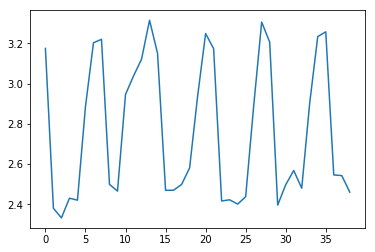

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.784791   
air_0164b9927d20bcc3_2017-04-23              1.424551   
air_0241aa3964b7f861_2017-04-23              2.460937   
air_0328696196e46f18_2017-04-23              2.155001   
air_034a3d5b40d5b1b1_2017-04-23              3.527932   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.958336  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.155992  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.715786  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.627898  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.053479

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l4_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')